## Nbdev import session

In [1]:
#default_exp kernel

In [2]:
#hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [3]:
#export
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier
from sklearn.pipeline import make_pipeline

from scipy import sparse
import numpy as np

from sparse_dot_topn import awesome_cossim_topn


In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [5]:
#export
def make_batches(arr, batch_size = 100):
    '''make batches for batch query'''
    #lst = [i for i in arr]

    if arr.shape[0] < batch_size:
        batches = [arr]
    else:
        n_bs = arr.shape[0] // batch_size
        last_batch = arr.shape[0] - batch_size * n_bs
        batches = []
        i = 0
        for i in range(n_bs):
            yield arr[i * batch_size:(i + 1) * batch_size]

        if last_batch:
            yield arr[(i + 1) * batch_size:]
    

In [6]:
def similarity_plot(vector, query_matrix):
    '''
    plots similarity plots like in https://gdmarmerola.github.io/forest-embeddings/
    '''
    return

In [7]:
# export
def sparsify(*arrs):
    '''
    makes input arrs sparse
    '''
    arrs = list(arrs)
    for i in range(len(arrs)):        
        if not sparse.issparse(arrs[i]):
            arrs[i] = sparse.csr_matrix(arrs[i])
    
    return arrs

def sim_matrix_to_idx_and_score(sim_matrix):
    '''
    returns list of indexes (col index of row vector) and scores (similarity value) for each row, given a similarity matrix
    '''
    scores = []
    idxs = []
    for row in sim_matrix:
        idxs.append(row.nonzero()[-1])
        scores.append(row.data)
    
    return idxs, scores

def cosine_similarity(A, B, topn = 30, remove_diagonal = False, **kwargs):        
    
    A,B = sparsify(A,B)
    A = normalize(A, norm  = 'l2').astype(np.float64)
    B = normalize(B, norm  = 'l2').astype(np.float64)
    dot = awesome_cossim_topn(A, B.T, ntop = topn, **kwargs)    
    
    if remove_diagonal:
        dot.setdiag(0)
        dot.eliminate_zeros()
    
    return dot


def cosine_distance(A, B, topn = 30, remove_diagonal = False, **kwargs):    
    
    #calculate sim
    dist = cosine_similarity(A, B, topn, remove_diagonal, **kwargs)
    #calculate distance
    dist.data = 1 - dist.data    
    return dist

# jaccard similarity not supported (does it even make sense?)
def jaccard_similarity(A, B, topn = 30, remove_diagonal = False, **kwargs):
    '''
    assumes that the ammount of non zero elements in the matrix are the same in all the columns
    and they are all equal to 1
    '''
    A,B = sparsify(A,B)
    
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    intersection = awesome_cossim_topn(A, B.T, ntop = topn, **kwargs)
    
    nnz_a = A.getnnz(axis=1)
    nnz_b = B.getnnz(axis=1)
    unions = nnz_a + nnz_b[intersection.indices] - intersection.data
    
    intersection.data = intersection.data/unions
    
    if remove_diagonal:
        intersection.setdiag(0)
        intersection.eliminate_zeros()
        
    return intersection

def jaccard_distance(A, B, topn = 30, remove_diagonal = False, **kwargs):
    #calculate sim
    dist = jaccard_similarity(A, B, topn, remove_diagonal, **kwargs)
    #calculate distance
    dist.data = 1 - dist.data    
    return dist

In [8]:
#export
def _robust_stack(blocks, stack_method = 'stack', **kwargs):
    
    if any(sparse.issparse(i) for i in blocks):
        stacked = getattr(sparse, stack_method)(blocks, **kwargs)
    else:
        stacked = getattr(np, stack_method)(blocks, **kwargs)
    return stacked

def hstack(blocks, **kwargs):
    return _robust_stack(blocks, stack_method = 'hstack', **kwargs)

def vstack(blocks, **kwargs):
    return _robust_stack(blocks, stack_method = 'vstack', **kwargs)

def stack(blocks, **kwargs):
    return _robust_stack(blocks, stack_method = 'stack', **kwargs)


class RobustEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,):            
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        return
    
    def fit(self, X, y = None, **kwawrgs):        
        self.ordinalencoder_ = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1).fit(X)
        
        X = self.ordinalencoder_.transform(X)
        
        categories = [np.arange(-1, len(cats)) for cats in self.ordinalencoder_.categories_]
        self.onehotencoder_ = OneHotEncoder(categories = categories).fit(X)        
        return self
    
    def transform(self, X, **kwargs):
        X = self.ordinalencoder_.transform(X)
        return self.onehotencoder_.transform(X)

In [9]:
x = [['aaa'], ['bbb'], ['ccc'], ['ddd']]
enc = RobustEncoder().fit(x)

enc.transform([['aaa'],['asdasd'], ['asd'],['ccc']]).A

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [10]:
#export
class EstimatorKernel(BaseEstimator, TransformerMixin):    
    '''
    creates a kernel with some specified estimator.
    projection method will be performed according to projection_method.
    projection method can be a string refering to estimators method used to project,
    or a callable, that receives the estimator and X (vector to be projected) as the inputs.
    should return the projections of X according to estimator.
    norm will normalize vectors in matrices prior to applying dot products.
    '''
    def __init__(self, estimator, projection_method = 'predict_proba', norm = 'l2'):
        '''
        creates a kernel with some specified estimator.
        projection method will be performed according to projection_method.
        projection method can be a string refering to estimators method used to project,
        or a callable, that receives the estimator and X (vector to be projected) as the inputs.
        should return the projections of X according to estimator.
        norm will normalize vectors in matrices prior to applying dot products.
        '''
        self.estimator = estimator
        self.projection_method = projection_method
        self.norm = norm
    
    def __getattr__(self, attr):
        '''
        Allows accessing self.estimator attributes if not found in first object level
        '''
        return getattr(self.estimator, attr)
    
    def transform(self, X):
        '''
        projects X into new space, according to projection_method
        '''
        if callable(self.projection_method):
            return self.projection_method(self.estimator, X)
        else:
            return getattr(self.estimator, self.projection_method)(X)            
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        '''
        X is the feature space,
        y is used only for supervised Kernels
        save_values are values associated with each "Embeding". During transform,
        the values of saved_values are retrieved according to indexes returned by Nearest Neighbor query        
        '''
        if not save_values is None:
            if not len(save_values) == len(X):
                raise IndexError(f'X and save_values must have the same shape along the first dimension. Got {X.shape} and {save_values.shape}')
        
        self.estimator.fit(X, y, **kwargs)
        
        self.train_projection_space_ = self.transform(X) #saves projection space of X in train
        self.train_projection_values_ = save_values #saves values to be retrieved by some query
        return self
        
    def similarity_matrix(self, A = None, B = None,  topn = 30, remove_diagonal = False, lower_bound = 0.0, metric = 'cosine'):
        '''
        reeturns pariwise_similarity of X and self.train_projection_space_
        if X is None, returns pariwise similarity of self.train_projection_space_ with itself
        '''
        
        METRICS = {
            'cosine':cosine_similarity,            
        }
        
        
        if A is None:
            A = self.train_projection_space_
        else:
            #transform to space
            A = self.transform(A)
        
        if B is None:
            B = self.train_projection_space_
        else:
            #transform to space
            B = self.transform(B)
        
        try:
            return METRICS[metric.lower()](
                #normalize first
                normalize(A, norm = self.norm, axis = 0),
                normalize(B, norm = self.norm, axis = 0),
                topn,
                remove_diagonal,
                lower_bound = lower_bound
            )
        except KeyError:
            raise AttributeError(f'metric should be one of {list(METRICS)}, got {metric}')
            
    def similarity_idxs(self, A = None, B = None, topn = 30, remove_diagonal = False, lower_bound = 0.0, alpha = None, metric = 'cosine'):
        '''
        performs dot product based similarity of normalized X versus normalized self.train_projection_space_.
        if X is None, returns similarity of self.train_projection_space_ within itself
        
        returns two lists, one of indexes and other of scores, the indexes refer to self.train_projecetion_space_ rows
        
        alpha is a concentration factor, such that similarity_values = similarity_values**alpha
        alpha > 1 implies spreading points appart
        0 < alpha < 1 implies bringing points closer together
        '''        
            
        sim_matrix = self.similarity_matrix(A, B, topn, remove_diagonal, lower_bound, metric)
        idxs, sim = sim_matrix_to_idx_and_score(sim_matrix)
        
        #use alpha concentration factor
        if not alpha is None:
            sim = [s**alpha for s in sim]
        
        return idxs, sim
    
    def similarity(self, A = None, B = None, topn = 30, remove_diagonal = False, lower_bound = 0.0, alpha = None, metric = 'cosine'):
        '''
        same as similarity, but instead of returning indexes, returns values in self.train_projection_values_
        '''
        idxs, sim = self.similarity_idxs(A, B, topn, remove_diagonal, lower_bound, alpha, metric)
        values = [self.train_projection_values_[idx] for idx in idxs]
        return values, sim
    
    def update_space(self, X, save_values):
        '''
        updates self.train_projection_space_ and self.train_projection_values_ with new data.
        new values are found running self.transform on X
        '''
        X = self.transform(X)
        
        self.train_projection_space_ = vstack([self.train_projection_space_, X])
        self.train_projection_values_ = vstack([self.train_projection_values_, save_values])
        return self

In [11]:
#export
class ForestKernel(EstimatorKernel):
    '''
    A Space tranformation performed based on Forest transformations.
    Can be supervised or not (CARTs, RandomTreeEmbeddings, Boosted trees...)
    
    the transformed space can be defined and the `decision_path` space or `terminal_nodes`
    space.
    '''             
    
    def __init__(self, estimator, embedding_space = 'decision_path'):
        self.embedding_space = embedding_space        
        super().__init__(estimator, projection_method = None, norm='l2')
        return
            
    def transform(self, X):
        
        if self.embedding_space == 'decision_path':
            
            X, n_nodes_ptr = self.estimator.decision_path(X)
            
        elif self.embedding_space == 'terminal_nodes':
            
            if hasattr(self, 'one_hot_node_embeddings_encoder_'):
                X = self.estimator.apply(X)
                X = self.one_hot_node_embeddings_encoder_.transform(X)

            else:
                X = self.estimator.apply(X)
                self.one_hot_node_embeddings_encoder_ = OneHotEncoder().fit(X)
                X = self.one_hot_node_embeddings_encoder_.transform(X)
                
        else:
            raise ValueError(f'embedding_space should be one of ["decision_path","terminal_nodes"], got {self.embedding_space}')
            
        return X 

In [12]:
class DenseTreeKernel():
    '''
    combines kernel tree, linear tree and mlp tree
    generating dense tree supervised embeddings
    '''

In [13]:
topn = 50
es1 = 'decision_path'
es2 = 'terminal_nodes'
alpha1 = 1.1
alpha2 = 0.9

In [14]:
kernel1 = ForestKernel(RandomTreesEmbedding(random_state = 42), embedding_space = es1)
kernel2 = ForestKernel(RandomTreesEmbedding(random_state = 42), embedding_space = es2)

kernel1.fit(X,)
kernel2.fit(X,)

ForestKernel(embedding_space='terminal_nodes',
             estimator=RandomTreesEmbedding(random_state=42))

In [15]:

_, sims1 = kernel1.similarity_idxs(X, remove_diagonal = True, topn = topn, alpha = alpha1)
_, sims2 = kernel2.similarity_idxs(X, remove_diagonal = True, topn = topn, alpha = alpha2)


C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


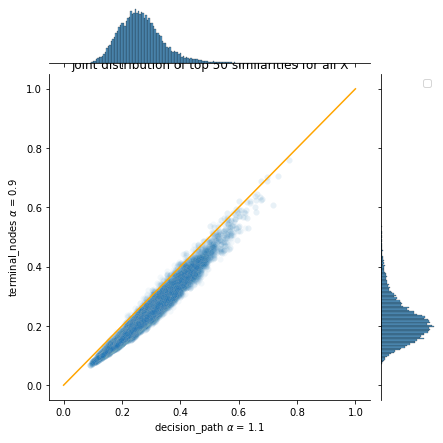

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sims1 = np.stack(sims1).flatten()
sims2 = np.stack(sims2).flatten()

#sns.distplot(dp_sims, label = fr'{es1} $\alpha$ = {alpha1}')
#sns.distplot(tn_sims, label = fr'{es2} $\alpha$ = {alpha2}')
plot = sns.jointplot(sims1, sims2, joint_kws = dict(alpha = 0.05))
plot.ax_joint.set_title(f'joint distribution of top {topn} similarities for all X')
plot.ax_joint.set_xlabel(fr'{es1} $\alpha$ = {alpha1}')
plot.ax_joint.set_ylabel(fr'{es2} $\alpha$ = {alpha2}')
plot.ax_joint.plot([0,1], [0,1], color = 'orange')
plt.legend()

points are closer to each other in decision_path space rather than in temrinal_nodes sapce

In [17]:
decision, ptr = RandomTreesEmbedding().fit(X).decision_path(X)

In [18]:
#export
class LinearKernel(EstimatorKernel):    
    '''
    Linear model kernel recommended for high cardinality one hot encoded categorical variables.
    kernel space is defined by liner model coefficients indexed by the nonzero elements
    of X
    
    If encode is set to true, a customized onehotencoder will encode the categorical input.
    
    This kernel will only work if the output of the one hot encoded vectors  have always the same number
    of nonzero elements (equal to the number of categorical features). Thus, its recomended to use the default
    encoder, because it asserts this condition is met during one hot encoding
    '''
    def __init__(self, estimator, norm = 'l2', encode = False):
        self.encode = encode
        super().__init__(estimator, norm)
        return    
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        
        if self.encode:
            self.estimator = make_pipeline(RobustEncoder(), self.estimator)
                                
        return super().fit(X, y, save_values, **kwargs)                                            
    
    def transform(self, X):
        '''
        multiplies sparse vector to its coef_ s from linear model.
        if multiclass classification, the number of final features will be
        n*original_n_features_before_one_hot_encoding
        '''
        
        if self.encode:
            coefs = self.estimator[-1].coef_
            X = self.estimator[0].transform(X)
        else:            
            coefs = self.estimator.coef_
        
        #create attr if it does now exist yet:
        #this line is supposed to run only during fit call
        if not hasattr(self,'dim_embeddings_'):
            self.dim_embeddings_ = len(X[0].data)
                
        if len(coefs.shape) == 1:
            coefs = coefs.reshape(1,-1)
        
        embeddings = []
        for dim in range(coefs.shape[0]):
            #assumes all rows have the same ammount of nonzero elements
            dim_embeddings = coefs[dim, X.nonzero()[1]].reshape(X.shape[0], self.dim_embeddings_)
            embeddings.append(dim_embeddings)                    
                
        return hstack(embeddings)
    

In [19]:
#export
def _get_sklearn_mlp_activations(self, X):
    hidden_layer_sizes = self.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + \
        [self.n_outputs_]
    activations = [X]
    for i in range(self.n_layers_ - 1):
        activations.append(np.empty((X.shape[0],
                                     layer_units[i + 1])))
    self._forward_pass(activations)
    return activations[-2]

class MLPKernel(EstimatorKernel):
    
    '''
    returns the output of last hidden layer (before softmax/linear layer)
    as space projection.
    
    Recomended for dimensionality reduction and Context specific bag of words task
    '''    
    def __init__(self, estimator, norm='l2'):
        self.projection_method = _get_sklearn_mlp_activations
        self.estimator = estimator
        self.norm = norm
        return
    
    

In [20]:
#export
class BOWKernel(MLPKernel):
    '''
    `MLPKernel` Alias, intended for Bag Of Words application.
    Generates supervised embeddings (context specific embeddings)
    '''
    pass

In [21]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

kernel_lin = LinearKernel(LogisticRegression(), encode = True)
kernel_mlp = MLPKernel(MLPClassifier((10,),))
kernel_lin.fit(X,y_class)
kernel_mlp.fit(X,y_class)

kernel_lin.transform(X).shape, kernel_mlp.transform(X).shape

C:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


((1000, 35), (1000, 10))

# Export

In [22]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted index.ipynb.
Converted kernel.ipynb.
